<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3e_OSI_SAF_sea_ice_mapping_Ice_Emissivity.ipynb" target="_blank"><< Mapping OSI SAF sea ice emissivity</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href=".1_4_OSI_SAF_sea_ice_THREDDS_example.ipynb" target="_blank">Accessing and mapping OSI SAF sea ice data via THREDDS >></a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sea-ice/HEAD?labpath=1_OSI_SAF_sea_ice_introductory%2F1_3d_OSI_SAF_sea_ice_mapping_ice_drift.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea ice parameters : Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb" target="_blank">1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb</a>**

</div>
<hr>

# 1.3f Mapping OSI SAF sea ice Index
### Data used 

| Dataset | EUMETSAT collection ID | OSI SAF website description | OSI SAF identifier |
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| Sea ice index | EO:EUM:DAT:0875  | <a href="https://osi-saf.eumetsat.int/products/osi-420" target="_blank">Description</a> | OSI-420   


### Learning outcomes

At the end of this notebook you will know;
* How to open Sea Ice Index netcdf
* Map Sea Ice Index

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Introduction to the Sea-Ice Index](#section1)
 2. [Mapping Sea-Ice Index - Monthly data](#section2)
 3. [Mapping Sea-Ice Index - Daily data](#section3)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports 
import os                                           # a library that allows us access to basic operating system commands
import xarray as xr                                 # a library that supports the use of multi-dimensional arrays in Python
import matplotlib.pyplot as plt                     # a library that supports plotting
import matplotlib.dates as dates                    # a part of the plotting library that provides date
import matplotlib.ticker as ticker                  # a part of the plotting library that provides ticks
import matplotlib.patches as mpatches               # a part of the plotting library that provides patches
from matplotlib.legend_handler import HandlerTuple  #
import numpy as np                                  # a library that supports array manipulation
import warnings                                     # a library that controls python warnings
from sklearn import linear_model                    # a function that calculate linear regression
import seaborn                                      # a library that supports plotting
import pandas as pd
from datetime import date, timedelta

warnings.filterwarnings('ignore')

##
<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Introduction to the Sea-Ice Index
[Back to top](#TOC-TOP)

</div>

The Sea Ice Index is a climate indicator of sea-ice coverage, for both the sea-ice extent and area over the last 45+ years and is continuously updated to present time. It provides basic values based on our Sea-Ice Concentration products, to allows graphic visualisation of the Sea Ice situation on both poles. Data up to the 31/12/2024 are based on our SMMR / SSM/I / SSMIS CDR and ICDR, and data from 01/01/2025 onward are based on our AMSR based ICDR as represent in the figure here below. It has made use of a large amount of available Microwave sensors over 45+ years.

<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-osi-saf-sea-ice/-/raw/main/img/SeaIceIndex_v3_timeline.png'>
<figcaption>Timeline displaying the relations between the different OSI SAF Sea-Ice Concentration Climate products and the Sea Ice Index</figcaption>
<br>

As we've seen in the notebook for <a href="./1_1a_OSI_SAF_sea_ice_FTP_data_access.ipynb">FTP data access</a>, these two concepts are different ways of computing Sea-Ice coverage:

* The **Sea-Ice Area** defined as the *area covered by Sea-Ice*
* The **Sea-Ice Extend** defined as the *the total grid-area where the Sea-Ice concentration exceed 15%*

<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-osi-saf-sea-ice/-/raw/main/img/Burgard_2020_SIA_vs_SIE.png'><br>
<figcaption>Difference between sea-ice area and sea-ice extent (inspired from <a href="https://www.ghrsst.org/wp-content/uploads/2021/04/SSTDefinitionsDiscussion.pdf" target="_blank">Burgard (2020)</a>)</figcaption>
<br>
In this notebook, we will concentrate on Sea-Ice Extend, but of course, the same manipulation can be done with Sea Ice Area.


The Sea Ice Index It consists of an updated series of graphs (.png) visualising the trends and evolution of sea ice at hemispheric, global and regional scales. These graphs, updated daily, are available directly on our <a href="https://osi-saf.eumetsat.int/sea-ice-index">website</a>. In addition to it, the data files (.txt and .nc) are available for users who are interested in analysing and plotting the data themselves. We will here manipulate these data. The Sea Ice Index is derived from the OSI SAF Global Sea Ice Concentration data, with R&D input from ESA CCI.<br>

The Sea Ice Index values have the same latency as the Sea-Ice Concentration ICDR it is based on (AMSR-2):
* the so-called **Fast-track files** are produced with a latency of one day. 
* the **nominal files** are produced with latency of 16 day. The nominal files erase the Fast-track ones once produced.

The nominal values are more reliable than the Fast-track ones. However, one wants to have an overview of the trends earlier than two weeks after. For this reason we do provide these lasts. <br>
Let's define the dates for the last file we should be working with. As we will use these later down, make sure you have downloaded the last version from our FTP server (on the same day you're following this notebook). If needed, follow the steps on the <a href="./1_1a_OSI_SAF_sea_ice_FTP_data_access.ipynb">dedicated notebook</a>.

In [2]:
current_date = date.today()

last_date = date.today() - timedelta(1)

ld_year =  str(last_date.year)
ld_month =  "{:02d}".format(last_date.month)
ld_day =  "{:02d}".format(last_date.day)

last_nominal_date = date.today() - timedelta(16)

lnd_year =  str(last_nominal_date.year)
lnd_month =  "{:02d}".format(last_nominal_date.month)
lnd_day =  "{:02d}".format(last_nominal_date.day)

print("today is the:", current_date)
print("the last date with value:", last_date)
print("the last nominal value date from:", last_nominal_date)

today is the: 2026-02-16
the last date with value: 2026-02-15
the last nominal value date from: 2026-01-31


##
<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Mapping sea ice Index - Monthly data
[Back to top](#TOC-TOP)

</div>

Monthly Data for sea ice extention exist for each hemisphere.

### Northern hemisphere

#### Plotting 

Setting directory where to read data files

In [3]:
directory = os.path.join(os.getcwd(), 'products', 'SI_index', 'nh')

Setting the Monthly data file

In [4]:
nc_file = os.path.join(directory, 'osisaf_nh_sie_monthly.nc')

We extract all the variable that we need to plot the Monthly records since 1978.

In [5]:
nc = xr.open_dataset(nc_file)
lat = nc.variables['lat'] # Latitude
lon = nc.variables['lon'] # Longitude
sie = nc.variables['sie'] # Sea Ice extention
time = nc.variables['time'][:] # Time
time = pd.to_datetime(time) # Transform datetime64 into datetime
nc.close()

Then, we can plot Sea Ice Extent in function of the time

Text(0.5, 1.0, 'Arctic Sea Ice Extent Monthly Time Series - 1978 to 2026')

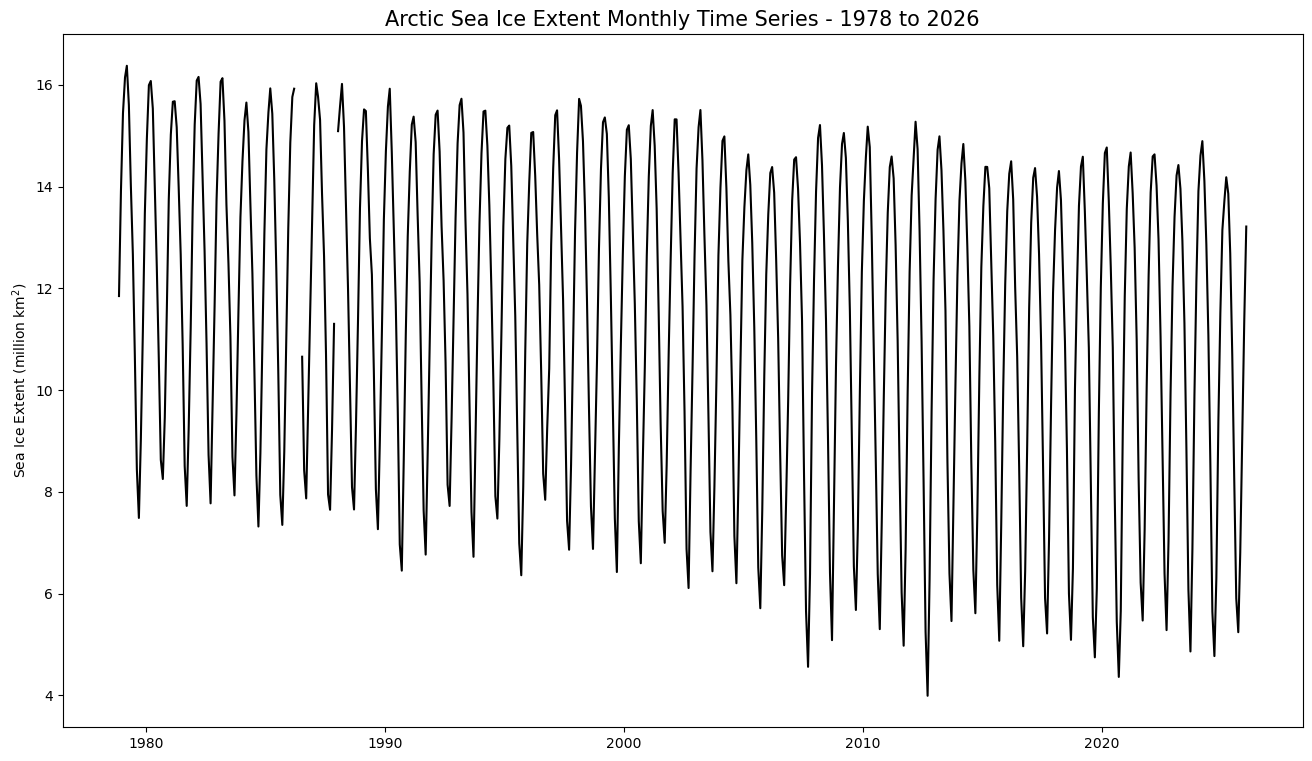

In [6]:
# Add figure
fig = plt.figure(figsize=(16,9))
# Plot Sea Ice Extent
plt.plot(time,sie, color='k')

# Add axes name and title
plt.ylabel("Sea Ice Extent (million km$^2$)", fontsize=10)
plt.title("Arctic Sea Ice Extent Monthly Time Series - 1978 to "+ld_year, fontsize=15)

This garphic do not show a lot of data about the extention of sea ice. In order to have more precise data It is possible to use a linear regression on maximum values (March values) and minimum values (September values). Then, we can calculate the mean difference of sea ice extent in the past years and decade.

In order to do that, we need to create a "new" axis x with float value instead of date. 
We create a list of integer *time_value* that associate each date with the number of month from the first date (here 1978 01 01)

In [7]:
time_value = [i for i in range(time.shape[0])]
time_value = np.asarray(time_value)

Sea Ice extent change with season, so, we need to separate maximum (end of winter) and minimum (end of summer) sea ice extent values. In the northern hemisphere maximum values are present during march month and minimum values during september month.

In [8]:
# Create list to store minimum and maximum sea ice extent values
min, max = [], []
# Create list to store the associate time value of miminim and maximum values sea ice extent
value_min, value_max = [], []

# Split minimum and maximum sea ice extent values
for i in range(0,time.shape[0],12):
    year = time_value[i:i+12] # Select one year
    sie_year = sie.values[i:i+12]
    index_min = np.nanargmin(sie_year) # Index of minimum value in the year
    index_max = np.nanargmax(sie_year) # Index of maximum value in the year
    
    # Adding values
    if index_min>6 and index_min<10:
        value_min.append(year[index_min])
        min.append(np.nanmin(sie_year))
    if index_max<4:
        value_max.append(year[index_max])
        max.append(np.nanmax(sie_year))

# transform list into array
value_min = np.asarray(value_min)
value_max = np.asarray(value_max)
min = np.asarray(min)
max = np.asarray(max)

Then, we can plot.
Plot sea ice extent with maximum and minimum sea ice extent values

Text(0.5, 1.0, 'Arctic Sea Ice Extent Monthly Time Series - 1978 to 2026')

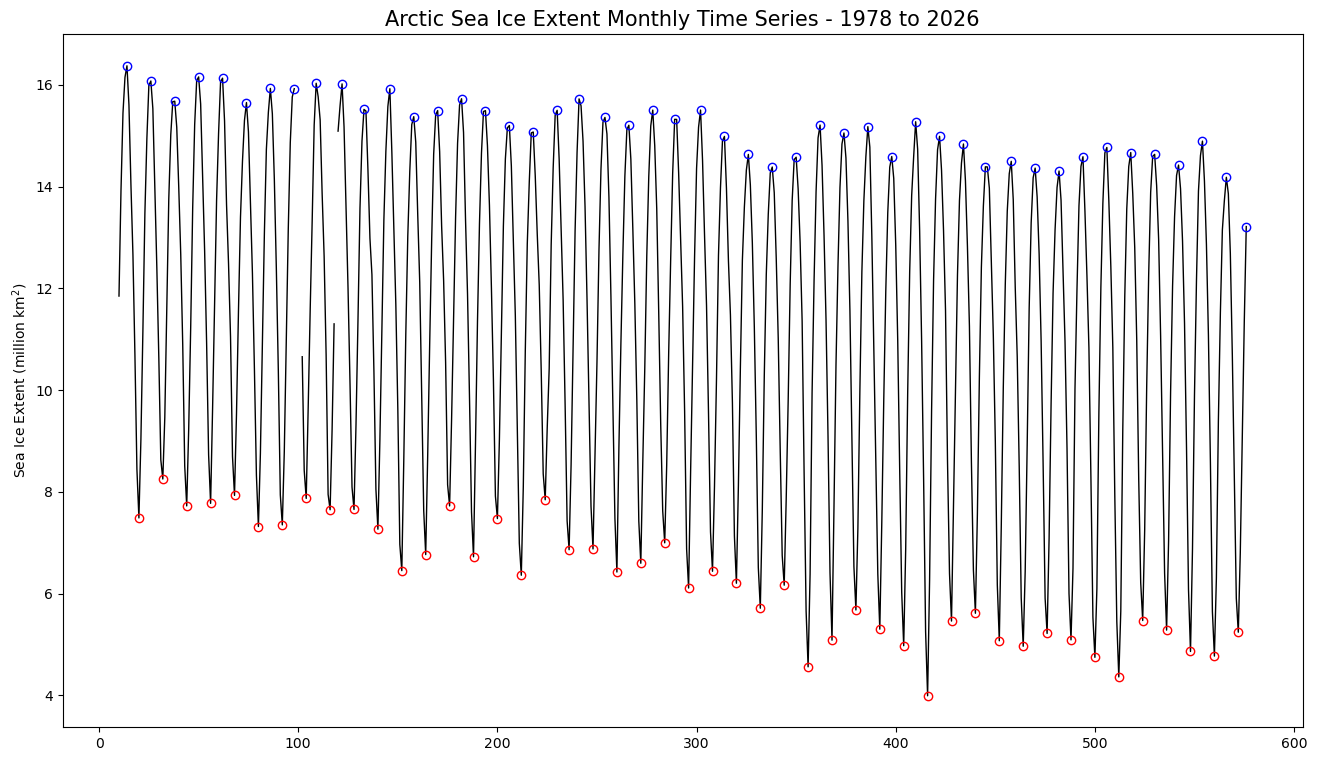

In [9]:
# Add figure
fig = plt.figure(figsize=(16,9))

# Plot 
plt.plot(time_value,sie, color='k', linewidth=1)
plt.plot(value_min, min, 'ro', fillstyle='none')
plt.plot(value_max, max, 'bo', fillstyle='none')

# Add title and axes names
plt.ylabel("Sea Ice Extent (million km$^2$)", fontsize=10)
plt.title("Arctic Sea Ice Extent Monthly Time Series - 1978 to "+ld_year, fontsize=15)

Add linear regression on maximum and minimum values

Text(0.5, 1.0, 'Arctic Sea Ice Extent Monthly Time Series - 1978 to 2026')

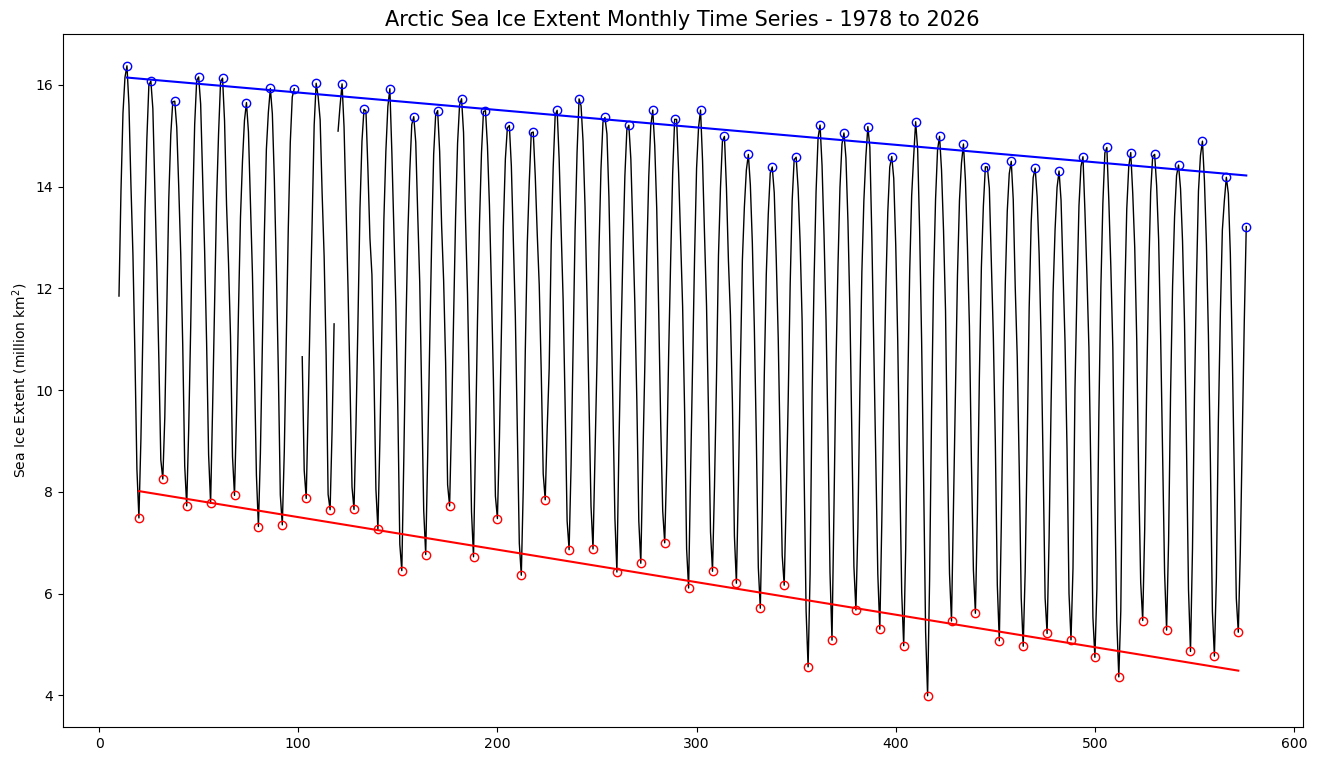

In [10]:
# Add figure
fig = plt.figure(figsize=(16,9))

# Linear regression for minimum values of sea ice extent
reg = linear_model.LinearRegression()
reg.fit(value_min.reshape(-1,1), min.reshape(-1,1))
min_pred = reg.predict(value_min.reshape(-1,1))

# Linear regression for maximum values of sea ice extent
reg = linear_model.LinearRegression()
reg.fit(value_max.reshape(-1,1), max.reshape(-1,1))
max_pred = reg.predict(value_max.reshape(-1,1))

# Plotting
plt.plot(time_value,sie, color='k', linewidth=1)
plt.plot(value_min, min, 'ro', fillstyle='none')
plt.plot(value_max, max, 'bo', fillstyle='none')
# Plot regression line
plt.plot(value_min, min_pred, color = "r") 
plt.plot(value_max, max_pred, color = "b") 

# Add title and axes names
plt.ylabel("Sea Ice Extent (million km$^2$)", fontsize=10)
plt.title("Arctic Sea Ice Extent Monthly Time Series - 1978 to "+ld_year, fontsize=15)

You can see that the x axis is not compose of date. 

We can change x label using matplotlib with the `.xticks` and `xticks_label` funtion. 

We decide to have x axis with year every 5 years until 2025.

Create the new x axis 

In [11]:
first_year = int(time[0].strftime('%Y')) # first year of data

print(first_year)

1978


In [22]:
# Date for x axis
start_date = 1980 # Start day to plot in axis x
end_date = 2030 # End date to plot in axis x

# Calcul the number of month from the first date of data
start = (start_date - first_year)*12
end = (end_date - first_year)*12

print(start_date,end_date)

1980 2030


In [23]:
# x axis in month
x = [i for i in range(start, end+1, 5*12)]
print(x)

[24, 84, 144, 204, 264, 324, 384, 444, 504, 564, 624]


In [24]:
# associate x axis with date 
date = [time[i].strftime('%Y') for i in x[:-1]]
date.append(str(end_date))
print(date)

['1980', '1985', '1990', '1995', '2000', '2005', '2010', '2015', '2020', '2025', '2030']


(0.0, 20.0)

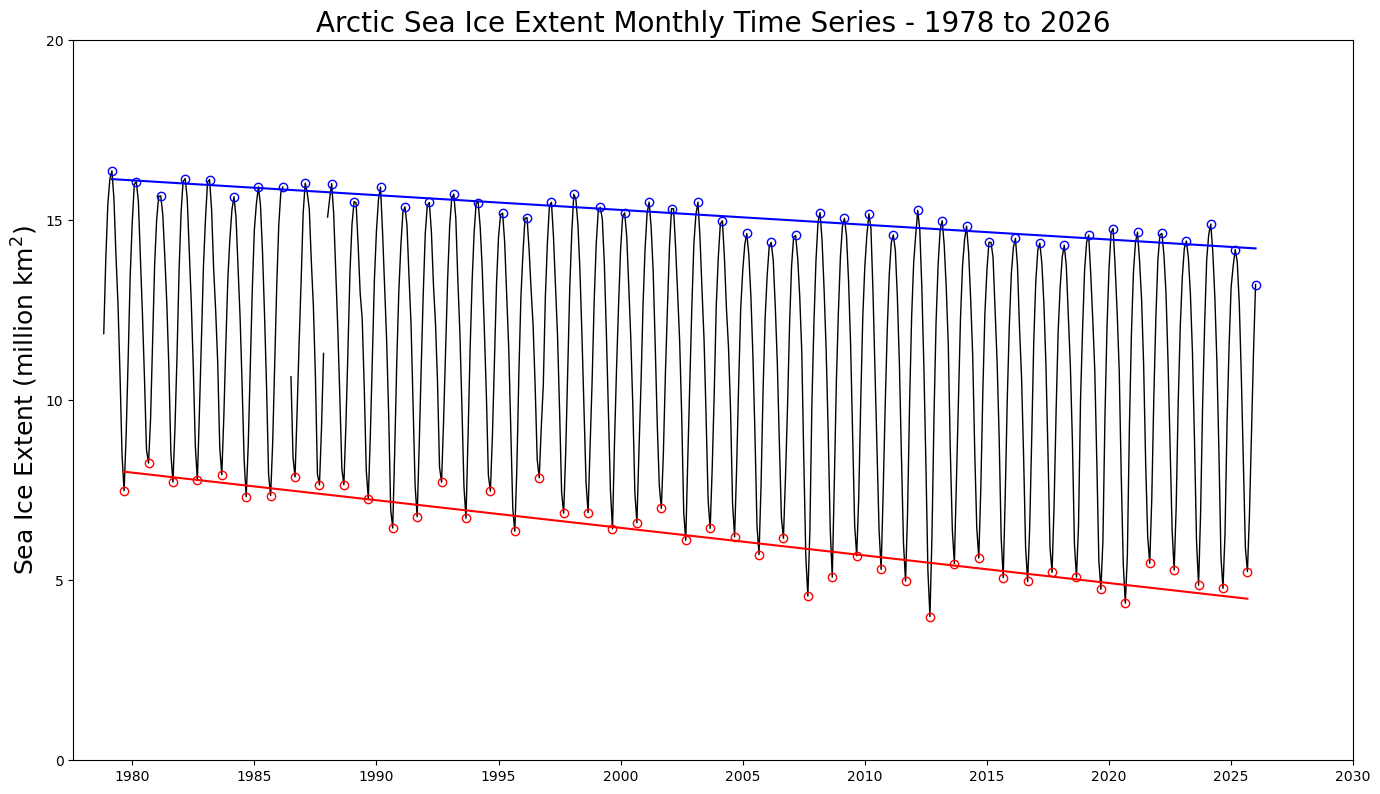

In [25]:
# Add figure
fig = plt.figure(figsize=(16,9))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Linear regression for minimum values of sea ice extent
reg = linear_model.LinearRegression()
reg.fit(value_min.reshape(-1,1), min.reshape(-1,1))
min_pred = reg.predict(value_min.reshape(-1,1))


# Linear regression for maximum values of sea ice extent
reg = linear_model.LinearRegression()
reg.fit(value_max.reshape(-1,1), max.reshape(-1,1))
max_pred = reg.predict(value_max.reshape(-1,1))


# Plotting
plt.plot(time_value,sie, color='k', linewidth=1)
plt.plot(value_min, min, 'ro', fillstyle='none')
plt.plot(value_max, max, 'bo', fillstyle='none')
# Plot regression line
plt.plot(value_min, min_pred, color = "r") 
plt.plot(value_max, max_pred, color = "b") 

# Add title and axes names
plt.ylabel("Sea Ice Extent (million km$^2$)", fontsize=18)
plt.title("Arctic Sea Ice Extent Monthly Time Series - "+str(first_year)+" to "+ld_year, fontsize=20)

# Chnage x-axis with date
ax.set_xticks(x)
ax.set_xticklabels(date)

# graduate y axis by 5
ax.set_yticks([i for i in range(0,20+1,5)])

# Add axis limit
ax.set_xlim(-5, end)
ax.set_ylim(0,20)

#### Calcul of sea ice extent difference over the past years 

Sea Ice Extent difference can be obtain by calculate the slope of the regression line. 

In [26]:
min_pred = min_pred.reshape(1,-1)
dif_min = (min_pred[0][1]-min_pred[0][0])*10**3/1
print(f"September Trend : \n{dif_min:.1f} thousand km2/year") 

ref = min_pred[0][0]*10**6
min_d = min_pred[0][10]*10**6
dif = (min_d - ref) / ref * 100
print(f"{dif:.1f} %/decade") 

September Trend : 
-76.7 thousand km2/year
-9.6 %/decade


In [27]:
max_pred = max_pred.reshape(1,-1)
dif_max = (max_pred[0][1]-max_pred[0][0])*10**3/1
print(f"March Trend :  \n{dif_max:.1f} thousand km2/year") 

ref = max_pred[0][0]*10**6
max_d = max_pred[0][10]*10**6
dif = (max_d - ref) / ref * 100
print(f"{dif:.1f} %/decade") 

March Trend :  
-41.1 thousand km2/year
-2.5 %/decade


### Southern hemisphere

#### Plotting 

Setting directory where to read data files

In [28]:
directory = os.path.join(os.getcwd(), 'products', 'SI_index', 'sh')

Setting the Monthly data file

In [29]:
nc_file = os.path.join(directory, 'osisaf_sh_sie_monthly.nc')

We extract all the variable that we need to plot the Monthly records since 1978.

In [30]:
nc = xr.open_dataset(nc_file)
lat = nc.variables['lat'] # Latitude
lon = nc.variables['lon'] # Longitude
sie = nc.variables['sie'] # Sea Ice extention
time = nc.variables['time'][:] # Time
time = pd.to_datetime(time) # Transform datetime64 into datetime
nc.close()

Then, we can plot Sea Ice Extent in function of the time

Text(0.5, 1.0, 'Antartic Sea Ice Extent Monthly Time Series - 1978 to 2026')

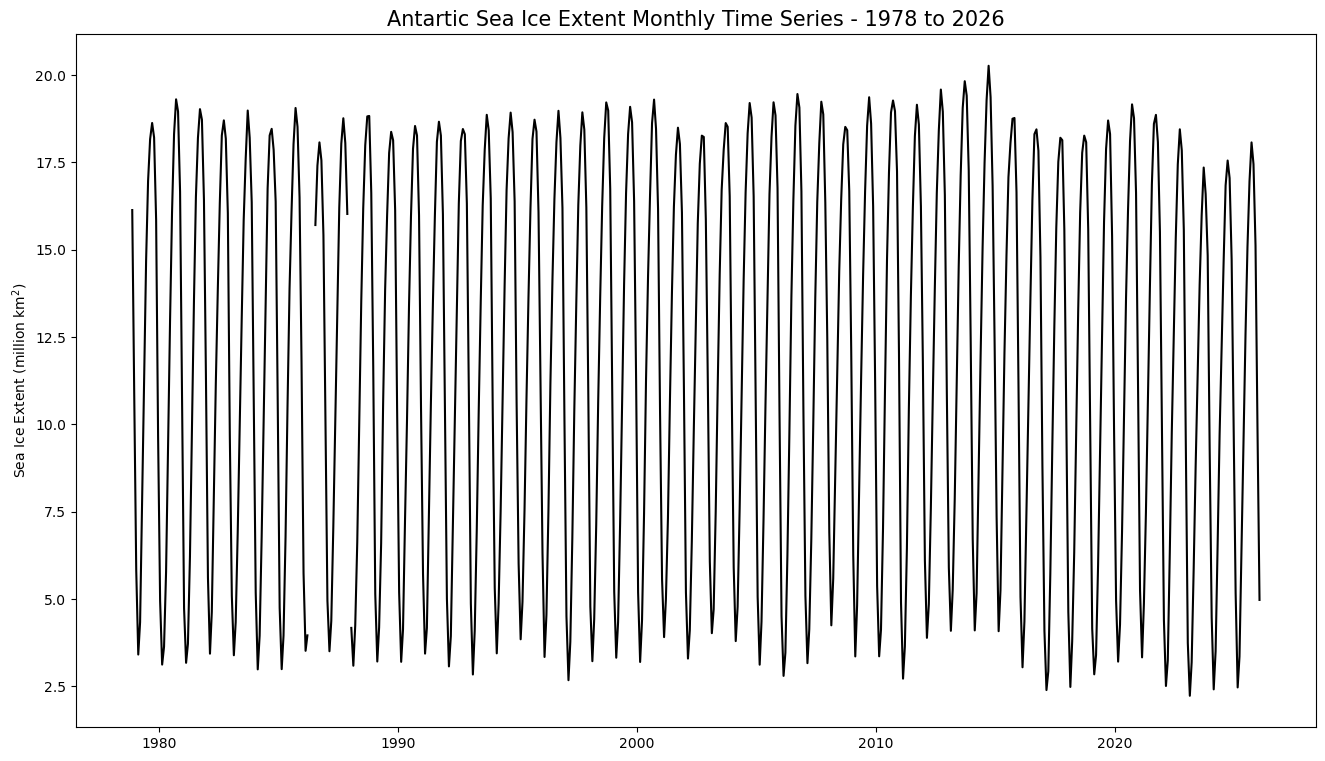

In [32]:
# Add figure
fig = plt.figure(figsize=(16,9))
# Plot Sea Ice Extent
plt.plot(time,sie, color='k')

# Add axes name and title
plt.ylabel("Sea Ice Extent (million km$^2$)", fontsize=10)
plt.title("Antartic Sea Ice Extent Monthly Time Series - "+str(first_year)+" to "+ld_year, fontsize=15)

This graphic do not show a lot of data about the extention of sea ice. In order to have more precise data It is possible to use a linear regression on maximum values (September values) and minimum values (February values). Then, we can calculate the mean difference of sea ice extent in the past years and decade.

In order to do that, we need to create a "new" axis x with float value instead of date. 
We create a list of integer *time_value* that associate each date with the number of month from the first date (here 1978 01 01)

In [33]:
time_value = [i for i in range(time.shape[0])]
time_value = np.asarray(time_value)

Sea Ice extent change with season, so, we need to separate maximum (end of winter) and minimum (end of summer) sea ice extent values. In the southern hemisphere maximum values are present during september month and minimum values during february month.

In [34]:
# Create list to store minimum and maximum sea ice extent values
min, max = [], []
# Create list to store the associate time value of miminim and maximum values sea ice extent
value_min, value_max = [], []

# Split minimum and maximum sea ice extent values
for i in range(0,time.shape[0],12):
    year = time_value[i:i+12] # Select one year
    sie_year = sie.values[i:i+12]
    index_min = np.nanargmin(sie_year) # Index of minimum value in the year
    index_max = np.nanargmax(sie_year) # Index of maximum value in the year
    
    # Adding values
    if index_min<5:
        value_min.append(year[index_min])
        min.append(np.nanmin(sie_year))
    if index_max>6 and index_max<10:
        value_max.append(year[index_max])
        max.append(np.nanmax(sie_year))

# transform list into array
value_min = np.asarray(value_min)
value_max = np.asarray(value_max)
min = np.asarray(min)
max = np.asarray(max)

Then, we can plot.
Plot sea ice extent with maximum and minimum sea ice extent values

Text(0.5, 1.0, 'Antartic Sea Ice Extent Monthly Time Series - 1978 to 2026')

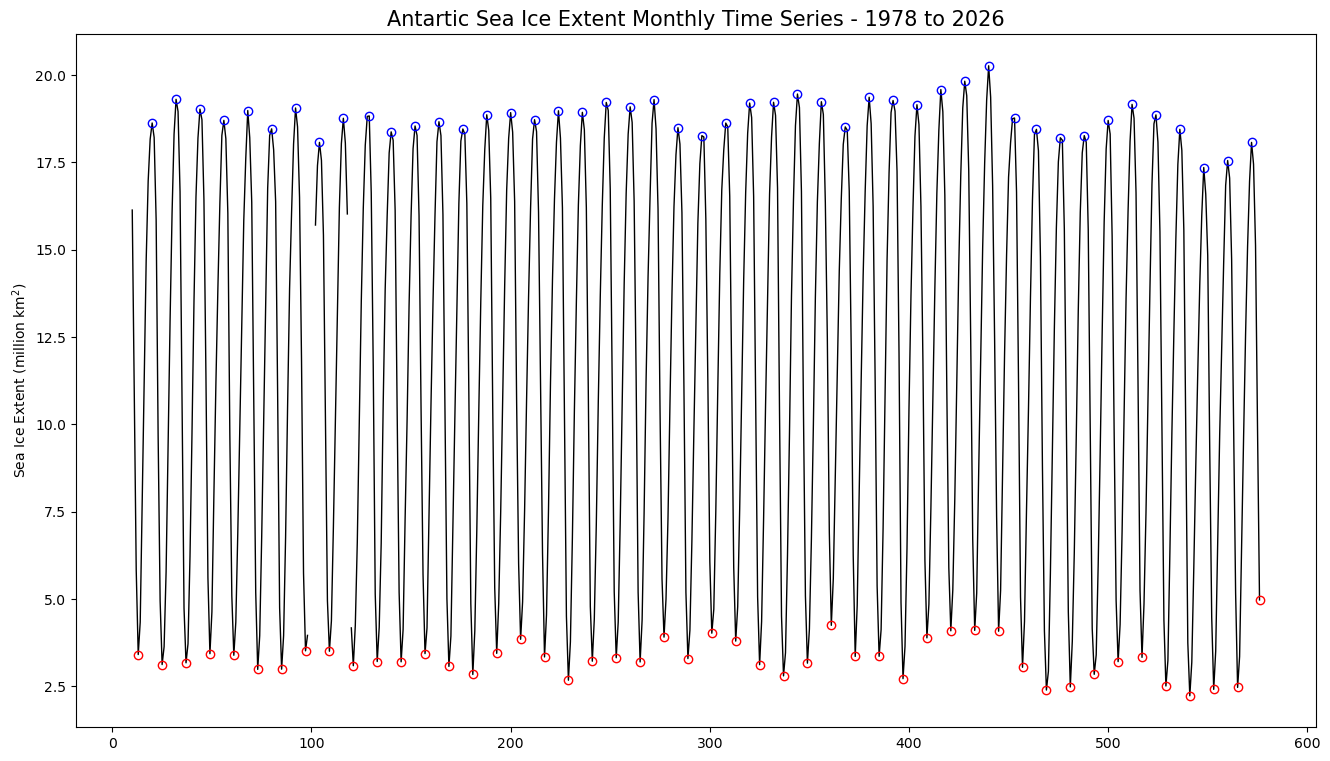

In [36]:
# Add figure
fig = plt.figure(figsize=(16,9))

# Plot 
plt.plot(time_value,sie, color='k', linewidth=1)
plt.plot(value_min, min, 'ro', fillstyle='none')
plt.plot(value_max, max, 'bo', fillstyle='none')

# Add title and axes names
plt.ylabel("Sea Ice Extent (million km$^2$)", fontsize=10)
plt.title("Antartic Sea Ice Extent Monthly Time Series - "+str(first_year)+" to "+ld_year, fontsize=15)

Add linear regression on maximum and minimum values

Text(0.5, 1.0, 'Antartic Sea Ice Extent Monthly Time Series - 1978 to 2026')

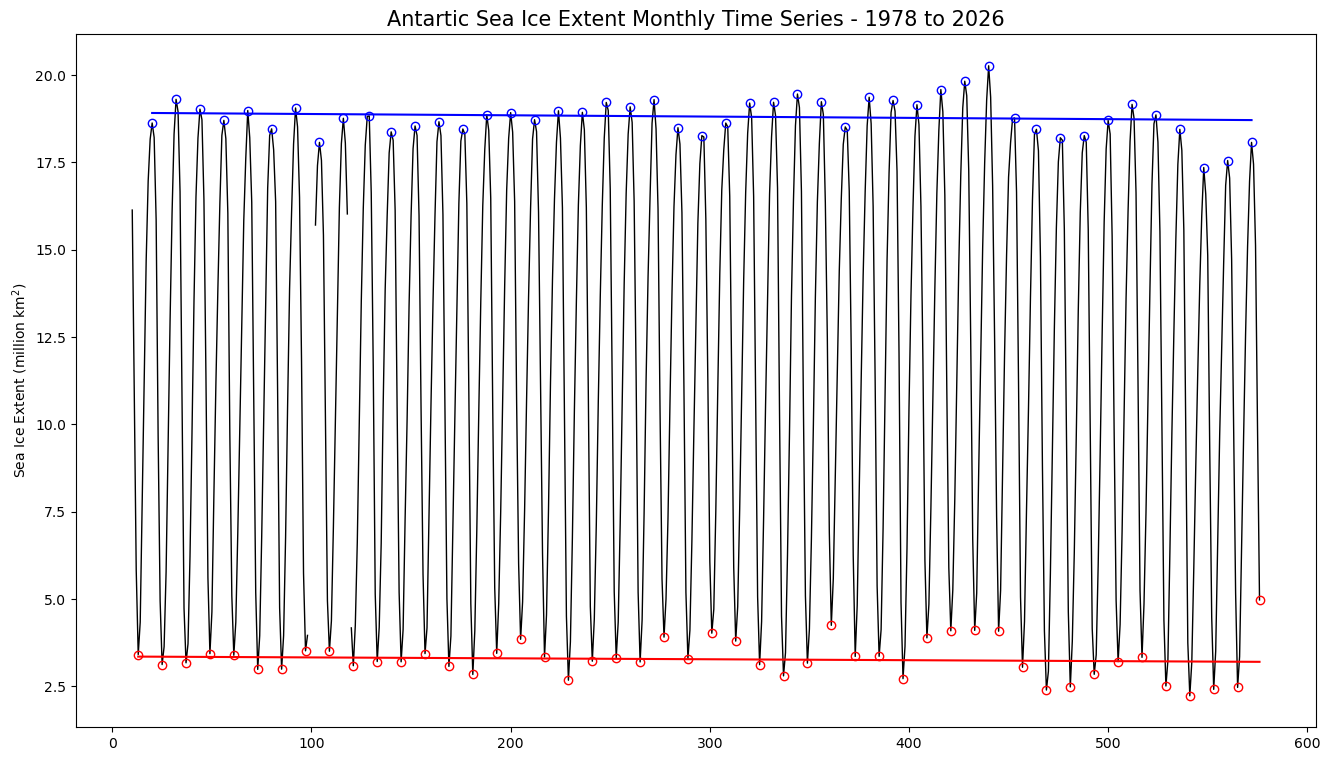

In [38]:
# Add figure
fig = plt.figure(figsize=(16,9))

# Linear regression for minimum values of sea ice extent
reg = linear_model.LinearRegression()
reg.fit(value_min.reshape(-1,1), min.reshape(-1,1))
min_pred = reg.predict(value_min.reshape(-1,1))

# Linear regression for maximum values of sea ice extent
reg = linear_model.LinearRegression()
reg.fit(value_max.reshape(-1,1), max.reshape(-1,1))
max_pred = reg.predict(value_max.reshape(-1,1))

# Plotting
plt.plot(time_value,sie, color='k', linewidth=1)
plt.plot(value_min, min, 'ro', fillstyle='none')
plt.plot(value_max, max, 'bo', fillstyle='none')
# Plot regression line
plt.plot(value_min, min_pred, color = "r") 
plt.plot(value_max, max_pred, color = "b") 

# Add title and axes names
plt.ylabel("Sea Ice Extent (million km$^2$)", fontsize=10)
plt.title("Antartic Sea Ice Extent Monthly Time Series - "+str(first_year)+" to "+ld_year, fontsize=15)

You can see that the x axis is not compose of date. 

We can change x label using matplotlib with the `.xticks` and `xticks_label` funtion. 

We decide to have x axis with year every 5 years until 2025.

Create the new x axis 

In [40]:
first_year = int(time[0].strftime('%Y')) # first year of data

print(first_year)

1978


In [41]:
# Date for x axis
start_date = 1980 # Start day to plot in axis x
end_date = 2030 # End date to plot in axis x

# Calcul the number of month from the first date of data
start = (start_date - first_year)*12
end = (end_date - first_year)*12

In [42]:
# x axis in month
x = [i for i in range(start, end+1, 5*12)]
print(x)

[24, 84, 144, 204, 264, 324, 384, 444, 504, 564, 624]


In [43]:
# associate x axis with date 
date = [time[i].strftime('%Y') for i in x[:-1]]
date.append(str(end_date))
print(date)

['1980', '1985', '1990', '1995', '2000', '2005', '2010', '2015', '2020', '2025', '2030']


(0.0, 25.0)

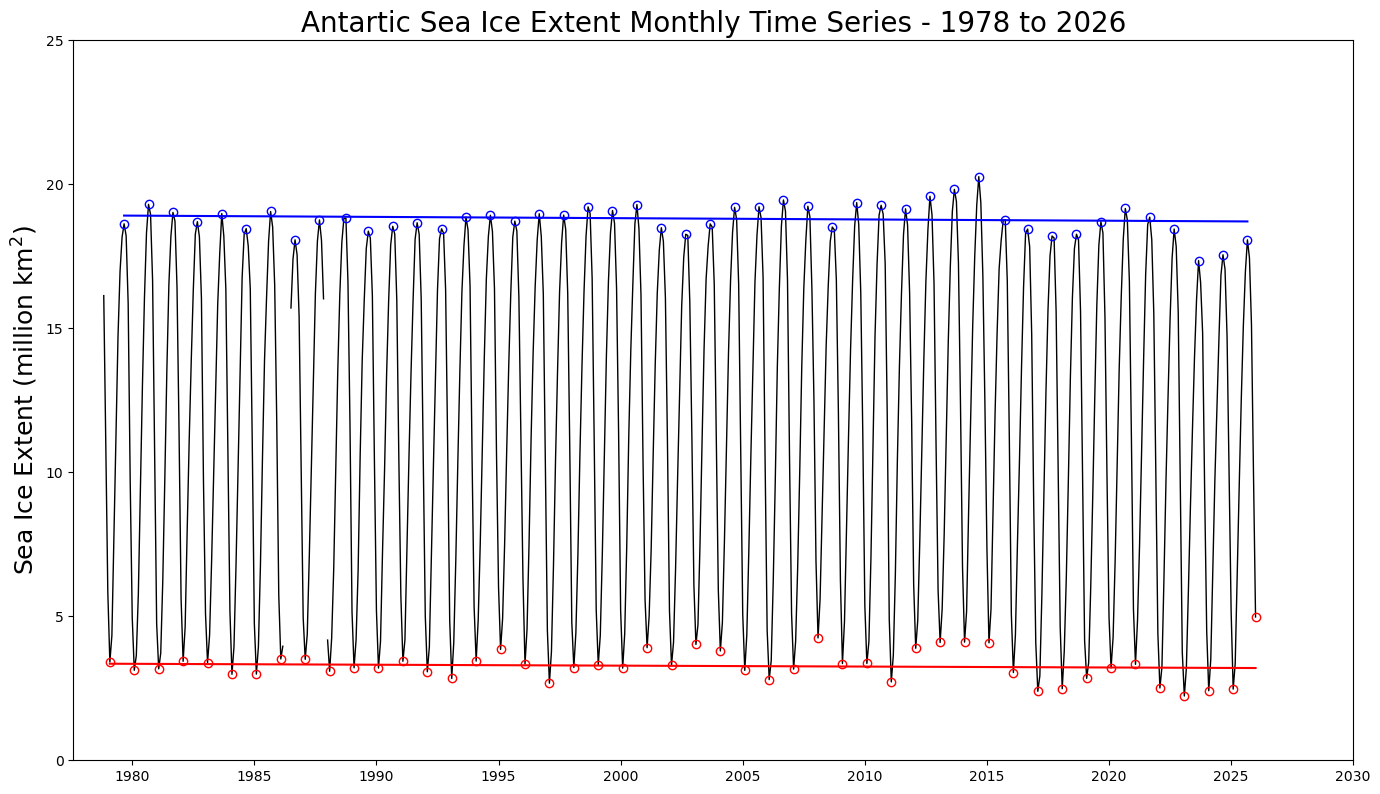

In [44]:
# Add figure
fig = plt.figure(figsize=(16,9))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Linear regression for minimum values of sea ice extent
reg = linear_model.LinearRegression()
reg.fit(value_min.reshape(-1,1), min.reshape(-1,1))
min_pred = reg.predict(value_min.reshape(-1,1))


# Linear regression for maximum values of sea ice extent
reg = linear_model.LinearRegression()
reg.fit(value_max.reshape(-1,1), max.reshape(-1,1))
max_pred = reg.predict(value_max.reshape(-1,1))


# Plotting
plt.plot(time_value,sie, color='k', linewidth=1)
plt.plot(value_min, min, 'ro', fillstyle='none')
plt.plot(value_max, max, 'bo', fillstyle='none')
# Plot regression line
plt.plot(value_min, min_pred, color = "r") 
plt.plot(value_max, max_pred, color = "b") 

# Add title and axes names
plt.ylabel("Sea Ice Extent (million km$^2$)", fontsize=18)
plt.title("Antartic Sea Ice Extent Monthly Time Series - "+str(first_year)+" to "+ld_year, fontsize=20)

# Chnage x-axis with date
ax.set_xticks(x)
ax.set_xticklabels(date)

# graduate y axis by 5
ax.set_yticks([i for i in range(0,25+1,5)])

# Add axis limit
ax.set_xlim(-5, end)
ax.set_ylim(0,25)

#### Calcul of sea ice extent difference over the past years 

Sea Ice Extent difference can be obtain by calculate the slope of the regression line. 

In [45]:
min_pred = min_pred.reshape(1,-1)
dif_min = (min_pred[0][1]-min_pred[0][0])*10**3/1
print(f"February Trend : \n{dif_min:.1f} thousand km2/year") 

ref = min_pred[0][0]*10**6
min_d = min_pred[0][10]*10**6
dif = (min_d - ref) / ref * 100
print(f"{dif:.1f} %/decade") 

February Trend : 
-3.2 thousand km2/year
-1.0 %/decade


In [46]:
max_pred = max_pred.reshape(1,-1)
dif_max = (max_pred[0][1]-max_pred[0][0])*10**3/1
print(f"September Trend :  \n{dif_max:.1f} thousand km2/year") 

ref = max_pred[0][0]*10**6
max_d = max_pred[0][10]*10**6
dif = (max_d - ref) / ref * 100
print(f"{dif:.1f} %/decade") 

September Trend :  
-4.4 thousand km2/year
-0.2 %/decade


##
<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Mapping sea ice Index - Daily data
[Back to top](#TOC-TOP)

</div>

### Northern hemisphere

Setting directory where to read data files

In [ ]:
directory = os.path.join(os.getcwd(), 'products', 'SI_index', 'nh')

Setting the Daily data file

In [ ]:
nc_file = os.path.join(directory, 'osisaf_nh_sie_daily.nc')

Extract usefull data

In [ ]:
nc = xr.open_dataset(nc_file)
lat = nc.variables['lat'] # Latitude
lon = nc.variables['lon'] # Longitude
sie = nc.variables['sie'] # Sea Ice extention
time = nc.variables['time'][:] # Time
time = pd.to_datetime(time) # Transform datetime64 into datetime

Create a dataframe to work with

In [ ]:
# Create a dateframe with Year, decade, Date and sie
year = [int(time[i].strftime('%Y')) for i in range(time.size)]
decade = [year[i]//10 * 10 for i in range(time.shape[0])]
df = pd.DataFrame(({'Year': year,
                        'Decade': decade,
                        'Date' : time.strftime('%m %d'),   
                        'sie':sie}))

# Select time to plot
start_year = 1980
end_year = df.iloc[-1].Year
data = df.loc[(df['Year'] >= start_year) & (df['Year'] < end_year)]

Plot sea ice daily index

In [ ]:
# Add figure
fig = plt.figure(figsize=(16,9))

# Create axis
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

# Color palette
color = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
    
# Plot by decade
index = 0
for y in range(start_year, end_year-1, 10):
    data_p = data.loc[(data['Decade'] == y)]
    seaborn.lineplot(data=data_p,x='Date', y='sie', hue='Year', legend=False,palette=color[index])
    index = index + 1
    
# Plot last year
now = df.loc[(df['Year'] == end_year)]
seaborn.lineplot(data=now,x='Date', y='sie', linewidth=3, color='black')

As you can see, there are too many tricks in x-axis. We will select 1 tick per month and replace it by the name of the month.

In [ ]:
# Add figure
fig = plt.figure(figsize=(16,9))

# Create axis
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

# Color palette
colors = [plt.cm.Purples_r, plt.cm.Blues_r, plt.cm.Greens_r, plt.cm.Oranges_r, plt.cm.Reds_r, 'black']
    
# Plot by decade
index = 0
for y in range(start_year, end_year-1, 10):
    data_p = data.loc[(data['Decade'] == y)]
    seaborn.lineplot(data=data_p,x='Date', y='sie', hue='Year', legend=False,palette=color[index])
    index = index + 1
    
# Plot last year
now = df.loc[(df['Year'] == end_year)]
seaborn.lineplot(data=now,x='Date', y='sie', linewidth=3, color='yellow')

# Add month ticks in x axis
x = ['0' + str(i) + ' 01' for i in range(1,10)]
x = x + [str(i) + ' 01'  for i in range(10,13)]
plt.xlim("01 01", "12 31")
ax.xaxis.set_major_locator(dates.MonthLocator())
# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
ax.tick_params(axis='x', which='minor', colors= 'k', tick1On=False, tick2On=False)
ax.tick_params(axis='y', colors= 'k')

# Add axis name
plt.ylabel('Sea Ice Extent (million km$^2$)', color='white')
plt.xlabel('Date', color='white')
plt.ylim(0,18)

# create a legend by decade
categories = ['1980\'s', '1990\'s', '2000\'s', '2010\'s', '2020\'s', str(date.today().year)]
colors = [plt.cm.Purples_r, plt.cm.Blues_r, plt.cm.Greens_r, plt.cm.Oranges_r, plt.cm.Reds_r, 'black']
legend_dict=dict(zip(categories,colors))
patchList = []
    
# Create patches of color
for cat, col in legend_dict.items():
    if cat != '2023':
        cmaplist = [col(i) for i in range(col.N-40)]
        patchList.append([mpatches.Patch(facecolor=c, label=cat) for c in cmaplist])
    else:
        patchList.append([mpatches.Patch(color=col, label="2023") for i in range(10)])
#Add legend
legend = plt.legend(handles=patchList, 
               labels=categories,  
               loc="lower left",
               labelcolor='k',
               borderpad=0.5,
               labelspacing=2,
               fontsize="15",
               handler_map = {list: HandlerTuple(None)})

print(date.today())


### Southern hemisphere

We follow the same processus for southern hemisphere

In [ ]:
directory = os.path.join(os.getcwd(), 'products', 'SI_index', 'sh')

In [ ]:
nc_file = os.path.join(directory, 'osisaf_sh_sie_daily.nc')

Select usefull variables

In [ ]:
nc = xr.open_dataset(nc_file)
lat = nc.variables['lat'] # Latitude
lon = nc.variables['lon'] # Longitude
sie = nc.variables['sie'] # Sea Ice extention
time = nc.variables['time'][:] # Time
time = pd.to_datetime(time) # Transform datetime64 into datetime

In [ ]:
# Create a dateframe with Year, decade, Date and sie
year = [int(time[i].strftime('%Y')) for i in range(time.size)]
decade = [year[i]//10 * 10 for i in range(time.shape[0])]
df = pd.DataFrame(({'Year': year,
                        'Decade': decade,
                        'Date' : time.strftime('%m %d'),   
                        'sie':sie}))

# Select time to plot
start_year = 1980
end_year = df.iloc[-1].Year
data = df.loc[(df['Year'] >= start_year) & (df['Year'] < end_year)]

In [ ]:
# Add figure
fig = plt.figure(figsize=(16,9))

# Create axis
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

# Color palette
colors = [plt.cm.Purples_r, plt.cm.Blues_r, plt.cm.Greens_r, plt.cm.Oranges_r, plt.cm.Reds_r, 'yellow']
    
# Plot by decade
index = 0
for y in range(start_year, end_year-1, 10):
    data_p = data.loc[(data['Decade'] == y)]
    seaborn.lineplot(data=data_p,x='Date', y='sie', hue='Year', legend=False,palette=color[index])
    index = index + 1
    
# Plot last year
now = df.loc[(df['Year'] == end_year)]
seaborn.lineplot(data=now,x='Date', y='sie', linewidth=3, color='yellow')

# Add month ticks in x axis
x = ['0' + str(i) + ' 01' for i in range(1,10)]
x = x + [str(i) + ' 01'  for i in range(10,13)]
plt.xlim("01 01", "12 31")
ax.xaxis.set_major_locator(dates.MonthLocator())
# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
ax.tick_params(axis='x', which='minor', colors= 'k', tick1On=False, tick2On=False)
ax.tick_params(axis='y', colors= 'k')

# Add axis name
plt.ylabel('Sea Ice Extent (million km$^2$)', color='white')
plt.xlabel('Date', color='white')
plt.ylim(0,25)

# create a legend by decade
categories = ['1980\'s', '1990\'s', '2000\'s', '2010\'s', '2020\'s', '2023']
colors = [plt.cm.Purples_r, plt.cm.Blues_r, plt.cm.Greens_r, plt.cm.Oranges_r, plt.cm.Reds_r, 'yellow']
legend_dict=dict(zip(categories,colors))
patchList = []
    
# Create patches of color
for cat, col in legend_dict.items():
    if cat != '2023':
        cmaplist = [col(i) for i in range(col.N-40)]
        patchList.append([mpatches.Patch(facecolor=c, label=cat) for c in cmaplist])
    else:
        patchList.append([mpatches.Patch(color=col, label="2023") for i in range(10)])
#Add legend
legend = plt.legend(handles=patchList, 
               labels=categories,  
               loc="upper left",
               labelcolor='k',
               borderpad=0.5,
               labelspacing=2,
               fontsize="15",
               handler_map = {list: HandlerTuple(None)})


<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3e_OSI_SAF_sea_ice_mapping_Ice_Emissivity.ipynb" target="_blank"><< Mapping OSI SAF sea ice emissivity</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href=".1_4_OSI_SAF_sea_ice_THREDDS_example.ipynb" target="_blank">Accessing and mapping OSI SAF sea ice data via THREDDS >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>